In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DLP/DLP_autoXRD/

Mounted at /content/drive
/content/drive/MyDrive/DLP/DLP_autoXRD


# Dependencies

In [ ]:
# Loads series of functions for preprocessing and data augmentation
from autoXRD import *
# Loads CAMs visualizations for a-CNN
from autoXRD_vis import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score

# Neural networks uses Keran with TF background
import keras as K
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling1D
from keras.models import load_model

import tensorflow as tf
from tensorflow import keras


# loading data

THeoretical data:

In [ ]:
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
theor = theor.iloc[1:,]
theor_arr=theor.values

# Normalize data for training
ntheor = normdata(theor_arr)

# Load labels for simulated data
label_theo = pd.read_csv('Datasets/label_theo.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

In [ ]:
ntheor.shape

(2125, 164)

Experimental data:

In [ ]:
# Load experimental data as dataframe
exp_arr_new = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr_new = exp_arr_new.values

# Load experimental class labels
label_exp= pd.read_csv('Datasets/label_exp.csv', index_col=0).values
label_exp = label_exp.reshape([len(label_exp),])

# Load class enconding
space_group_enc_mapping = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc_mapping['0'])

# Normalize experimental data
nexp = normdata(exp_arr_new)

# Define spectral range for data augmentation
exp_min = 0
exp_max = 1200
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing (nexp, exp_min, exp_max, window))

In [ ]:
post_exp.shape

(1200, 88)

In [ ]:
space_group_enc

['Fm-3m', 'I41mcm', 'P21a', 'P3m1', 'P61mmc', 'Pc', 'Pm-3m']

# Data augmentation

In [ ]:
################################################################
# Perform data augmentation
################################################################

# Specify how many data points we augmented
th_num = 2000

# Augment data, this may take a bit
augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)

# Enconde theoretical labels
label_t=np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i]=space_group_enc.index(pard[i])

# Input the num of experimetal data points
exp_num =88

# Prepare experimental arrays for training and testing
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]

# Prepare simulated arrays for training and testing
X_th = np.transpose(crop_augd )
y_th = label_t


In [ ]:
x = np.concatenate((X_exp, X_th), axis=0)
y = np.concatenate((y_exp, y_th), axis=0)

#split  data to reserve some test data
x_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


pandas.core.frame.DataFrame

# Data preparation

In [ ]:

def data_prep():
    enc = OneHotEncoder()

    train_dim = x_train.reshape(x_train.shape[0],1200,1)
    train_y = y_train
    train_y_hot = enc.fit_transform(train_y.reshape(-1,1)).toarray()  # Convert to dense array

    # Define test data
    test_x = X_test.reshape(X_test.shape[0],1200,1)
    test_y = enc.fit_transform(y_test.reshape(-1,1)).toarray()

    if isinstance(train_y_hot, tf.sparse.SparseTensor):
        train_y_hot = tf.sparse.to_dense(train_y_hot)

    return train_dim, train_y_hot, test_x, test_y, class_mapping




In [ ]:
y_train[:6]

array([6., 6., 0., 0., 4., 1.])

In [ ]:
np.unique(y_train)

array([0., 1., 2., 3., 4., 5., 6.])

In [ ]:
np.unique(label_theo)

array(['Fm-3m', 'I41mcm', 'P21a', 'P3m1', 'P61mmc', 'Pc', 'Pm-3m'],
      dtype='<U6')

In [ ]:
label_theo[:6]

['Fm-3m', 'Fm-3m', 'Fm-3m', 'Fm-3m', 'Fm-3m', 'Fm-3m']

# Defining different models

below you can write a function where we define specific models which can be loaded, evaluated and for which we can plot a confusion matrix

## CNN model

In [ ]:

# Define network structure
def a_cnn_model(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

## CNN model with batchnorm

I experimented with a CNN model which has batchnorm but I found that only 1 batchnorm layer works the best

In [ ]:

# Define network structure
def batchnorm_model(train_dim, train_y_hot, test_x, test_y):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(train_dim, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(test_x, test_y))
    return model, hist

# Decision tree

In [ ]:
import xgboost as xgb
def decision_tree(train_dim, train_y_hot):

    # Convert one-hot encoding to class indices
    #have to convert one hot back to indices
    y_train = np.argmax(train_y_hot, axis=1)
    x_training = train_dim.reshape(train_dim.shape[0], -1)
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(x_training, label=y_train)
    # dtest = xgb.DMatrix(X_test, label=y_test)

    # XGBoost parameters for multiclass classification
    params = {
        "objective": "multi:softmax",  # Multi-class classification
        "num_class": 7,  # Number of classes
        "eval_metric": "mlogloss",  # Multi-class log loss
    }

    # Train the model
    num_round = 100  # Number of boosting rounds
    model = xgb.train(params, dtrain, num_round)

    return model

# Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def conf_matrix(model):
    prediction = model.predict(test_x)
    # For a classification task, convert predictions to class labels (if needed)
    prediction_ord=[np.argmax(element) for element in prediction]


    # If your true labels are one-hot encoded, you may need to convert them as well
    true_labels = [np.argmax(element) for element in test_y]

    cm = confusion_matrix(true_labels, prediction_ord, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
    disp.plot()
    plt.show()
    return None

NameError: name 'train_y' is not defined

# ROC Curves

Using ROC to evaluate multiple classes requires more consideration.
We have used the one-vs-rest (OVR) stategy, which is also refered to as the one-vs-all strategy. In this method, the ROC for each class is determined where a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk.

We consider both the micro-averaging and macro-averaging.

In micro-averaged OvR, the average metrics are computed as:
$$ TPR = \frac{\sum_CTP_C}{\sum_C(TP_C + FN_C)};$$
$$ FPR = \frac{\sum_CFP_C}{\sum_C(FP_C + TN_C)}.$$
Mainly, the contributions from all the classes are considered. Note, this is usefull for highly imbalanced classes as not all classses are treated equally prior to the calculation.

For macro-averaging, the metrics are computed independently for each class and then taking the average over them.
$$ TPR = \frac{1}{C}\sum_C\frac{TP_C}{TP_C + FN_C};$$
$$ FPR = \frac{1}{C}\sum_C\frac{FP_C}{FP_C + TN_C}.$$

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_OVR(model, test_x, test_y, X_test=None):
  """
  Determines and plots the ROC for the class vs rest classification.
  """
  prediction = model.predict(test_x)

  n_classes = len(np.unique(label_theo))

  # Compute ROC curve and AUC for each class
  fpr, tpr, roc_auc = dict(), dict(), dict()

  # ROC for each class
  for i in range(n_classes):  # 7 classes
      fpr[i], tpr[i], _ = roc_curve(test_y[:, i], prediction[:, i])
      roc_auc[i]= auc(fpr[i], tpr[i])


  # Micro-average ROC curve and AUC
  fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), prediction.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and AUC
  fpr_grid = np.linspace(0.0 , 1.0, 1000)

  # linear interpolate all ROC curves at the points
  mean_tpr = np.zeros_like(fpr_grid)
  for i in range(n_classes):
      mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

  # average it and then compute macros AUC
  mean_tpr /= n_classes

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  #### Plotting all together ####

  plt.figure(figsize=(6, 6))

  # Plot ROC for each class
  colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
  for i, color in enumerate(colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label=f'{space_group_enc[i]} (AUC = {roc_auc[i]:.2f})')

  # Plot micro and macro average ROC curves
  plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
           label=f'Micro Avg (AUC = {roc_auc["micro"]:.2f})', lw=2)
  plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='gray',
           label=f'Macro Avg (AUC = {roc_auc["macro"]:.2f})', lw=2)

  # Plot diagonal line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--',
           label = "Chance level (AUC = 0.5)")

  # Labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-Class ROC Curve')
  plt.legend(loc='lower right')
  plt.show()


In [ ]:
def plot_roc_OVR_Tree(model, X_test, test_y):
  """
  Determines and plots the ROC for the class vs rest classification.
  """
  dtest = xgb.DMatrix(X_test, label=y_test)

  y_pred = model.predict(dtest)

  fpr, tpr, _ = roc_curve(test_y, y_pred)
  roc_auc = auc(fpr, tpr)

   #### Plotting all together ####

  plt.figure(figsize=(6, 6))

  # Plot micro and macro average ROC curves
  plt.plot(fpr,tpr, linestyle='--', color='black',
           label=f'Micro Avg (AUC = {roc_auc:.2f})', lw=2)

  # Plot diagonal line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--',
           label = "Chance level (AUC = 0.5)")

  # Labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-Class ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

# Training different models

## CNN

In [ ]:
train_dim, train_y_hot, test_x, test_y, class_mapping = data_prep()
cnn_model, _ = a_cnn_model(train_dim, train_y_hot, test_x, test_y)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - categorical_accuracy: 0.0405 - loss: 0.6849 - val_categorical_accuracy: 0.0431 - val_loss: 0.6450
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - categorical_accuracy: 0.0396 - loss: 0.6186 - val_categorical_accuracy: 0.0431 - val_loss: 0.5108
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.0340 - loss: 0.4829 - val_categorical_accuracy: 0.0431 - val_loss: 0.4199
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.1338 - loss: 0.4088 - val_categorical_accuracy: 0.3325 - val_loss: 0.3841
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3365 - loss: 0.3775 - val_categorical_accuracy: 0.3325 - val_loss: 0.3805
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3313 - loss: 0.3794 - val_categorical_accuracy: 0.3325 - val_loss: 0.3790
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.3273 - loss: 0.3766 - val

## CNN with batchnorm

In [ ]:
cnn_batchnorm_model, _ = batchnorm_model(train_dim, train_y_hot, test_x, test_y)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - categorical_accuracy: 0.1674 - loss: 0.6521 - val_categorical_accuracy: 0.3278 - val_loss: 0.6547
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.3345 - loss: 0.5098 - val_categorical_accuracy: 0.3278 - val_loss: 0.5499
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.4046 - loss: 0.3769 - val_categorical_accuracy: 0.3278 - val_loss: 0.4745
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.4171 - loss: 0.3521 - val_categorical_accuracy: 0.3278 - val_loss: 0.4915
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.4608 - loss: 0.3372 - val_categorical_accuracy: 0.3278 - val_loss: 0.4853
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.4684 - loss: 0.3224 - val_categorical_accuracy: 0.3278 - val_loss: 0.4917
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.4699 - loss: 0.

## Decision tree

In [ ]:
model_tree = decision_tree(train_dim, train_y_hot)

# Evaluating the models

## CNN

In [ ]:
type(model_tree)

xgboost.core.Booster

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.6661 - loss: 0.2212
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


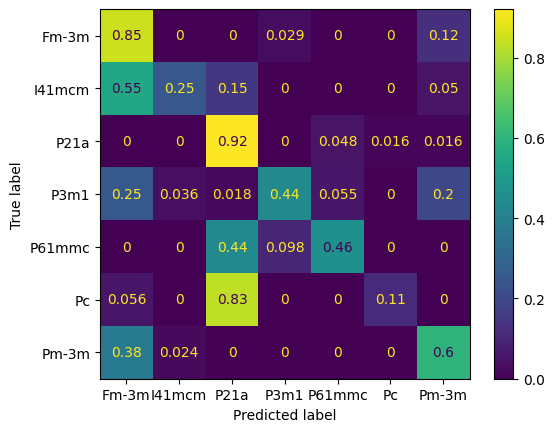

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


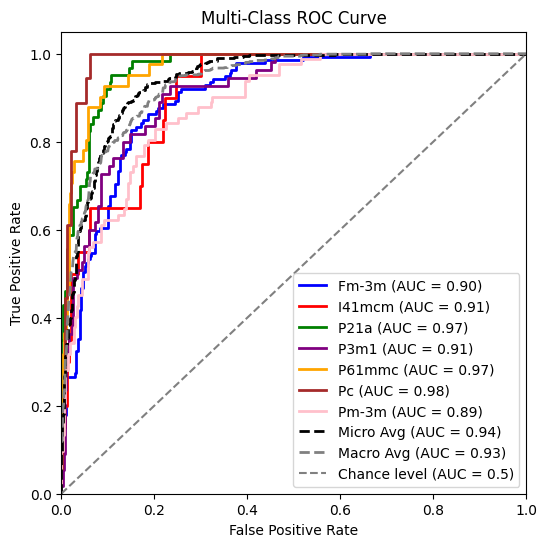

In [ ]:
cnn_model.evaluate(test_x, test_y, return_dict = True)
conf_matrix(cnn_model)
plot_roc_OVR(cnn_model, test_x, test_y)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


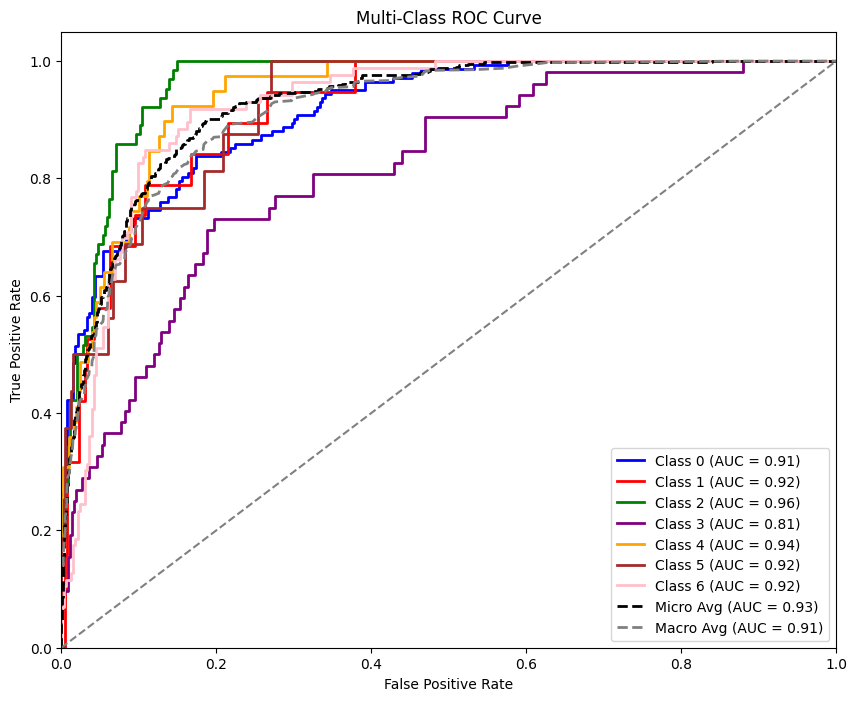

## CNN with batchnorm

Only 1 batchnorm layer. Works the best for me

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


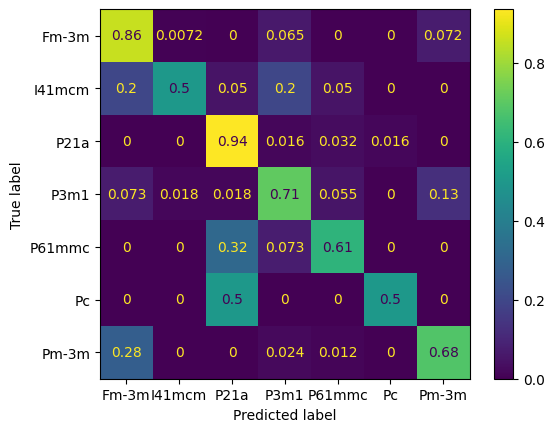

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.7789 - loss: 0.1708


TypeError: plot_roc_OVR() takes 3 positional arguments but 4 were given

In [ ]:
conf_matrix(cnn_batchnorm_model)
cnn_batchnorm_model.evaluate(test_x, test_y, return_dict = True)
plot_roc_OVR(cnn_batchnorm_model, test_x, test_y)

## Decision tree

In [ ]:
y_pred.shape

(418,)

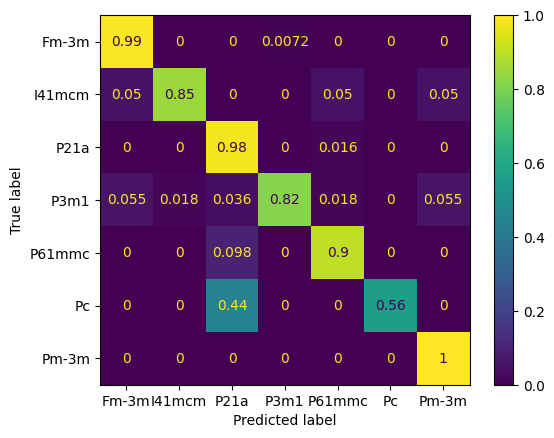

Accuracy: 0.9354066985645934


In [ ]:
from sklearn.metrics import accuracy_score

dtest = xgb.DMatrix(X_test, label=y_test)

y_pred = model_tree.predict(dtest)

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
disp.plot()
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


In [ ]:
plot_roc_OVR_Tree(model_tree, X_test, test_y)

ValueError: multilabel-indicator format is not supported

xgboost.core.Booster

In [ ]:
type(cnn_model)

keras.src.models.sequential.Sequential